In [1]:
"""
From Ahmad:
I would suggest to try multiple models for classification
and regression and compare them to make your project more
significant. Also focus a bit more on the EDA part and try
to make an interesting analysis with nice visualisations.
There could be interesting questions which could be answered
by your analysis, eg: which category of the projects have a
higher success rate. Also if this data-set was already used
in a kaggle competition, you can also report and compare your
accuracy with the accuracy of the wining team of the
competition in kaggle.
"""

'\nFrom Ahmad:\nI would suggest to try multiple models for classification\nand regression and compare them to make your project more\nsignificant. Also focus a bit more on the EDA part and try\nto make an interesting analysis with nice visualisations.\nThere could be interesting questions which could be answered\nby your analysis, eg: which category of the projects have a\nhigher success rate. Also if this data-set was already used\nin a kaggle competition, you can also report and compare your\naccuracy with the accuracy of the wining team of the\ncompetition in kaggle.\n'

In [2]:
# imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the data

In [3]:
df = pd.read_csv("../data/ks-projects-201801.csv")
df.head(5)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


# Data cleaning
Data to clean:
* deadline, launched --> datetime

No categorical data in the form of integers --> using strings is fine

The Kaggle user already converted amounts to USD --> we will use these columns


Remove undefined/live/suspended (about 2.1% of the data) --> focus on historical data

In [4]:
df["deadline"] = pd.to_datetime(df["deadline"])
df["launched"] = pd.to_datetime(df["launched"])
df.dtypes

ID                           int64
name                        object
category                    object
main_category               object
currency                    object
deadline            datetime64[ns]
goal                       float64
launched            datetime64[ns]
pledged                    float64
state                       object
backers                      int64
country                     object
usd pledged                float64
usd_pledged_real           float64
usd_goal_real              float64
dtype: object

# EDA

Text(0, 0.5, 'Main Category')

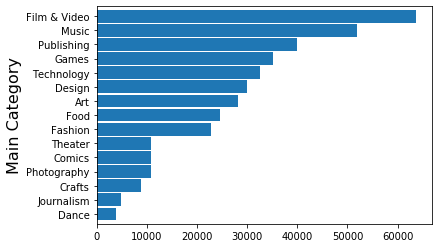

In [5]:
df_main_cat = df.groupby(["main_category"])["ID"].nunique().sort_values(ascending=True)
ax = df_main_cat.plot(kind="barh", x="main_category", width=0.9)
ax.set_ylabel("Main Category", size=16)

Text(0.5, 1.0, 'Distribution of states')

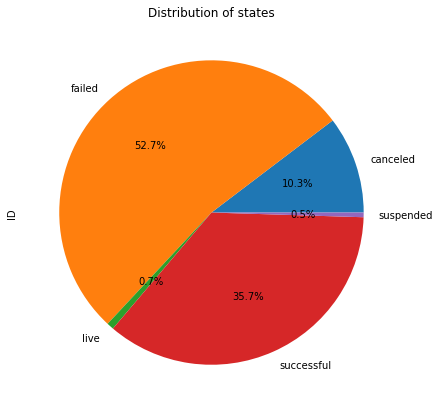

In [6]:
df_state = df[(df["state"] != "undefined")].groupby(["state"])["ID"].nunique()
ax = df_state.plot(kind="pie", figsize=(7,7), autopct="%1.1f%%")
ax.set_title("Distribution of states")

Text(0.5, 1.0, '5 most represented countries')

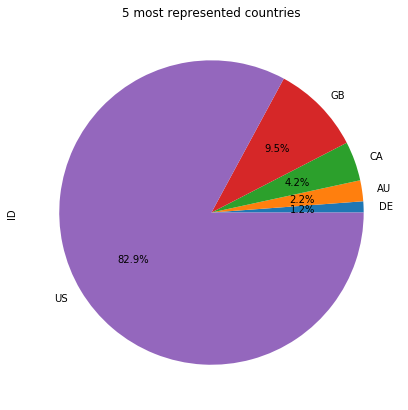

In [9]:
df_country = df.groupby(["country"])["ID"].count().sort_values()
ax = df_country.tail(5).plot(kind="pie", figsize=(7,7), autopct="%1.1f%%")
ax.set_title("5 most represented countries")

EDA emeryfl dollars